
# Entropy from ancestry coefficients (q) and genotype probabilities (gprob)  

Does everything to run entropy and creates slurm files to submit

Goal is 4 chains k=2-X (you decide)

**Create conda env just for entropy**  
`conda create -n entropy`  
`conda activate entropy`  
`conda install popgen-entropy`  


## SUBSET2: 

#### This is a subset of individuals decided by ERNA_analyses

In [1]:
import sys
import ipyparallel as ipp
import os
from os import environ
import gzip
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import glob
import re
import random

In [2]:
root = "/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/"

In [3]:
cd $root

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO


In [4]:
!mkdir entropy_sub2

mkdir: cannot create directory ‘entropy_sub2’: File exists


In [5]:
ent_dir =os.path.join(root,'entropy_sub2')
assert ent_dir

In [6]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2


#### Subset vcf file by Pop_ID_sub.csv

In [7]:
%load_ext rpy2.ipython

In [9]:
%%R
require(readr)
require(MASS)
require(LEA)
require(tidyverse)
require(ggsci)

source('/data/gpfs/assoc/denovo/src/R/Imports.R')

setwd('/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2')

Pop_ID_sub <- read.csv('Pop_ID_sub.csv')
print(nrow(Pop_ID_sub))
print(table(as.character(Pop_ID_sub$Variety)))

[1] 228

   arenaria   bigelovii  graveolens   hololueca      iridis      juncea 
          5           8          11          71           6          11 
latisquamea  mohavensis        nana      nitida   oreophila salicifolia 
          6           5           5           6          28          22 
   speciosa   turbinata 
         33          11 


In [10]:
%%R 
# write file with individuals to keep 
keep_sub <- data.frame(INDV=as.character(Pop_ID_sub$All))
write.table(keep_sub,'keep_sub.txt',row.names=FALSE,quote=FALSE)

In [11]:
!cp ../SNPcall/filtering/good_snps.recode.vcf.gz .

#### Filter vcf to keep only subset individuals AND same MAF (0.02) / missing data (0.7)

In [12]:
!vcftools --gzvcf 'good_snps.recode.vcf.gz' \
--max-missing 0.7 \
--maf 0.02 \
--recode \
--recode-INFO-all \
--keep 'keep_sub.txt' \
--out 'ERNA_sub'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf good_snps.recode.vcf.gz
	--keep keep_sub.txt
	--recode-INFO-all
	--maf 0.02
	--max-missing 0.7
	--out ERNA_sub
	--recode

Using zlib version: 1.2.11
Keeping individuals in 'keep' list
After filtering, kept 228 out of 586 Individuals
Outputting VCF file...
After filtering, kept 19724 out of a possible 22917 Sites
Run Time = 13.00 seconds


In [13]:
vcf_sub = 'ERNA_sub.recode.vcf'
vcf_sub_gz = vcf_sub + ".gz"
!bgzip -c $vcf_sub > $vcf_sub_gz
!tabix $vcf_sub_gz

In [14]:
!rm 'ERNA_sub.log'
!rm 'ERNA_sub.recode.vcf.gz.tbi'

In [15]:
!vcftools --gzvcf 'ERNA_sub.recode.vcf.gz' \
--012 \
--out 'ERNA_sub.recode.vcf.gz'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ERNA_sub.recode.vcf.gz
	--012
	--out ERNA_sub.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 228 out of 228 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 19724 out of a possible 19724 Sites
Run Time = 2.00 seconds


### Create mgpl & pntest files with associated dir 

#### copy good_snps.recode.vcf.gz from filtering

In [16]:
vcf = 'ERNA_sub.recode.vcf'
vcf

'ERNA_sub.recode.vcf'

In [17]:
perl_mpgl = '/data/gpfs/assoc/denovo/src/perl_scripts/vcf2mpgl_universal.pl'
perl_mean = '/data/gpfs/assoc/denovo/src/perl_scripts/gl2genest_universal.pl'

In [18]:
!perl $perl_mpgl $vcf

Number of loci: 19724; number of individuals 228


In [19]:
mpgl = 'ERNA_sub.recode.mpgl'

In [20]:
!perl $perl_mean $mpgl mean

### Create ldak files in R

In [21]:
%%R
g <- read.table("pntest_mean_ERNA_sub.recode.txt", header=F)
dim(g)

[1] 19724   228


In [22]:
%%R

#create Pop_ID file 

indv<-read.table("ERNA_sub.recode.vcf.gz.012.indv",sep="\t")

Pop_ID <- data.frame(Pop=rep(NA,times=nrow(indv)),
                     ID=NA,
                     All=NA)
for (i in 1:nrow(indv)){
    name_list <-unlist(strsplit(as.character(indv$V1[i]),"_"))
    Pop_ID$Pop[i] <- name_list[2]
    Pop_ID$ID[i] <- as.integer(name_list[3])
    Pop_ID$All[i] <- as.character(indv$V1[i])
}
#print(head(Pop_ID))
#print(length(unique(Pop_ID$Pop)))

### merge with Pop_ID_sub
Pop_ID_sub <- left_join(Pop_ID,Pop_ID_sub[,1:10])

Joining, by = c("Pop", "ID", "All")


In [23]:
%%R
pca_df <- PCA_entropy(t(g))

    PC1     PC2     PC3     PC4     PC5 
0.06467 0.05184 0.04512 0.02768 0.01961 


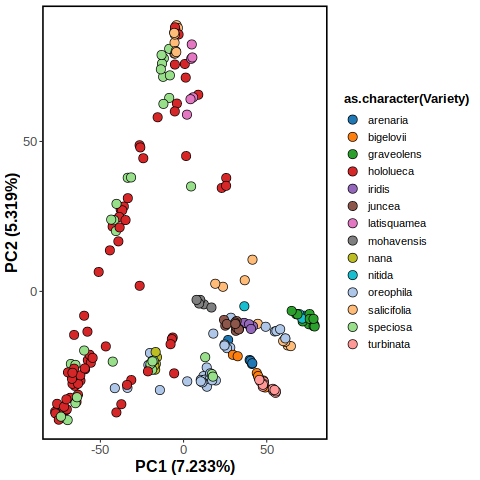

In [24]:
%%R

### check pntest_mean PCA looks okay
pca_df <- cbind(pca_df[,1:10],Pop_ID_sub)


ggplot(data = pca_df, aes(x=PC1,y=PC2,fill=as.character(Variety))) +
  geom_point(pch=21,colour='black',size = 4) + 
  xlab(paste("PC",1," (",0.07233*100,"%)",sep="")) + 
  ylab(paste("PC",2," (",0.05319*100,"%)",sep="")) +
  scale_fill_d3(palette='category20') +
  theme_bw() + 
  theme(#legend.position = 'none',
        axis.text = element_text(size=13),
        axis.title = element_text(size = 16, colour="black",
                                  face = "bold",vjust = 1),
        panel.border = element_rect(size = 1.5, colour = "black"),
        legend.text = element_text(size = 11),
        legend.title = element_text(size = 13, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())


In [25]:
%%R
#######################################################################################
                                    #### LDA ####
#######################################################################################

k2<-kmeans(pca_df[,1:5],2,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k3<-kmeans(pca_df[,1:5],3,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k4<-kmeans(pca_df[,1:5],4,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k5<-kmeans(pca_df[,1:5],5,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k6<-kmeans(pca_df[,1:5],6,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k7<-kmeans(pca_df[,1:5],7,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k8<-kmeans(pca_df[,1:5],8,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k9<-kmeans(pca_df[,1:5],9,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k10<-kmeans(pca_df[,1:5],10,iter.max=10,nstart=10,algorithm="Hartigan-Wong")
k11<-kmeans(pca_df[,1:5],11,iter.max=10,nstart=10,algorithm="Hartigan-Wong")

ldak2<-lda(x=pca_df[,1:5],grouping=k2$cluster,CV=TRUE)
ldak3<-lda(x=pca_df[,1:5],grouping=k3$cluster,CV=TRUE)
ldak4<-lda(x=pca_df[,1:5],grouping=k4$cluster,CV=TRUE)
ldak5<-lda(x=pca_df[,1:5],grouping=k5$cluster,CV=TRUE)
ldak6<-lda(x=pca_df[,1:5],grouping=k6$cluster,CV=TRUE)
ldak7<-lda(x=pca_df[,1:5],grouping=k7$cluster,CV=TRUE)
ldak8<-lda(x=pca_df[,1:5],grouping=k8$cluster,CV=TRUE)
ldak9<-lda(x=pca_df[,1:5],grouping=k9$cluster,CV=TRUE)
ldak10<-lda(x=pca_df[,1:5],grouping=k10$cluster,CV=TRUE)
ldak11<-lda(x=pca_df[,1:5],grouping=k11$cluster,CV=TRUE)

write.table(round(ldak2$posterior,5),file="ldak2.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak3$posterior,5),file="ldak3.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak4$posterior,5),file="ldak4.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak5$posterior,5),file="ldak5.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak6$posterior,5),file="ldak6.txt",quote=F,row.names=F,col.names=F)                                      
write.table(round(ldak7$posterior,5),file="ldak7.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak8$posterior,5),file="ldak8.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak9$posterior,5),file="ldak9.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak10$posterior,5),file="ldak10.txt",quote=F,row.names=F,col.names=F)
write.table(round(ldak11$posterior,5),file="ldak11.txt",quote=F,row.names=F,col.names=F)


In [26]:
%%R
######### create entropy header ####

Pop_ID_list <- paste(Pop_ID$Pop,Pop_ID$ID,sep='_')

Header <- data.frame(dims = NA,Pop_ID_list)

dim(g)

df <- t(Header)
dims <- paste(dim(g)[2],dim(g)[1],sep = " ")

df[1,1] <- dims

write.table(df,'entropy_header.txt',sep = " ",na ="",
            quote = FALSE,row.names = FALSE,col.names = FALSE)

In [27]:
!head entropy_header.txt

228 19724                                                                                                                                                                                                                                   
AR_2 AR_3 AR_4 AR_5 AR_6 AS_19 AS_22 AS_24 AS_28 AS_29 AS_30 BC_10 BC_11 BC_12 BC_1 BC_2 BC_3 BC_4 BC_5 BC_6 BC_7 BC_8 BC_9 BH_1 BH_2 BH_3 BH_4 BH_5 BH_6 BO_1 BO_2 BO_3 BO_4 BO_5 BO_6 BT_1 BT_2 BT_3 BT_4 BT_5 BT_6 BV_19 BV_20 BV_24 BV_26 BV_27 BV_28 CH_2 CH_3 CH_4 CH_5 CH_6 CH_7 CI_1 CI_2 CI_3 CI_4 CI_5 CN_1 CN_2 CN_4 CN_5 CN_6 CO_1 CO_2 CO_3 CO_4 CO_5 DC_11 DC_12 DC_15 DC_1 DC_5 DC_8 EW_11 EW_12 EW_3 EW_4 EW_7 EW_9 GB_17 GB_18 GB_20 GB_21 GB_23 GB_30 HL_1 HL_2 HL_3 HL_4 HL_5 HO_10 HO_15 HO_1 HO_4 HO_6 HO_7 IO_1 IO_2 IO_3 IO_4 IO_5 JO_2 JO_3 JO_4 JO_5 JO_6 JT_1 JT_2 JT_3 JT_4 JT_5 JT_6 LA_1 LA_2 LA_3 LA_4 LA_5 LA_6 LO_1 LO_2 LO_3 LO_4 LO_5 LR_1 LR_2 LR_3 LR_4 LR_5 LR_6 LT_4 LT_5 LT_6 LV_16 LV_17 LV_18 LV_25 LV_26 LV_27 MD_11 MD_13 MD_15 MD_2 MD_3 MD_9 N

In [28]:
!cat entropy_header.txt ERNA_sub.recode.mpgl > entropy.mpgl

In [29]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2


In [30]:
!mkdir shdir

In [31]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '14-00:00:00' #time limit 4
cpus = 4 #to prevent hammering one node
mem_cpu = 8000
email = 'tfaske@nevada.unr.edu'

#entropy settings
l = 60000
b = 10000
num_k = [2,3,4,5,6,7,8,9]
chains = 4

**Note:** Random seed needs to be created for each chain. Most programs use the clock as the seed, which is typically fine but since the clock on the HPC only goes to minutes and we are running everything at the same time, all the seeds are the same. Giving you the same exact seed. 

In [32]:
def write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains):
    for k in num_k:
        for c in range(1,chains+1):
            jobname = 'k%d_c%d' % (k,c)
            seed = random.randint(1000,9999) #default is clock so messes up if submitted same time 
            with open("shdir/run_entropy_%s.sh" % (jobname), "w") as o:
                o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name ent_%s
#SBATCH --output output_%s.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,jobname,jobname,email))
        
                o.write("entropy -i ../entropy.mpgl -o ../entropy_%s.hdf5 -r %d -n 2 -l %d -b %d -t 10 -s 50 -e .01 -k %d -q ../ldak%d.txt -m 1 -w 0"
                        % (jobname,seed,l,b,k,k))
    

In [33]:
write_entropy_sh(account,partition,time,cpus,mem_cpu,email,l,b,num_k,chains)

In [34]:
entShells = !find $ent_dir -name 'run_entropy*.sh'
entShells = entShells.sort()
entShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k2_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k2_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k2_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k2_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k3_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k3_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k3_c3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k3_c4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k4_c1.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy_k4_c2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_entropy

In [35]:
def write_sbatch_entShells(entShells):
         with open("shdir/sbatch_entropy.sh", "w") as o:
            o.write("""#!/usr/bin/env bash \n""")
            for sh in entShells:
                o.write("""sbatch %s\n""" % (sh))

In [36]:
write_sbatch_entShells(entShells)

# Run all entropy*sh
    cd /data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy/shdir
    source activate entropy
    bash sbatch_entropy.sh

# Use estpost to get DIC, q, and gprob

In [37]:
np.set_printoptions(precision=8) # increases float print option
#pd.set_option("precision", 8)

In [38]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2


In [39]:
hdf5_files = !find . -name '*hdf5'
hdf5_files = hdf5_files.sort()
#hdf5_files

In [40]:
estpost = '/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy'

In [41]:
#make DIC
for i in range(0,len(hdf5_files)):
    f = hdf5_files[i]
    k = f.split('_')[1] #set this 
    c = f.split('_')[2].split('.hdf5')[0]
    #print(k,c)
    dic = "DIC_%s_%s.txt" % (k,c)
    !$estpost $f -s 3 -p deviance > $dic

In [42]:
dic_files = !find . -name 'DIC*'
len(dic_files),dic_files[0]

(32, './DIC_k2_c4.txt')

In [43]:
for d in dic_files:
    !cat $d
    print('\n')

file = ./entropy_k2_c4.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 7401388.47
Effective number of parameters: 3593059.78
Model DIC: 10994448.25


file = ./entropy_k7_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 6362655.73
Effective number of parameters: 5826211.62
Model DIC: 12188867.35


file = ./entropy_k2_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 7401239.80
Effective number of parameters: 3619357.04
Model DIC: 11020596.84


file = ./entropy_k6_c1.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 6446061.98
Effective number of parameters: 5650481.31
Model DIC: 12096543.29


file = ./entropy_k3_c2.hdf5
parameter dimensions for deviance: samples = 5000, chains = 1
Model deviance: 7024561.34
Effective number of parameters: 4050216.31
Model DIC: 11074777.65


file = ./entropy_k4_c4.hdf5
parameter dimensions for deviance: samples = 50

In [44]:
dic_list = []
for d in dic_files:
    k = d.split('_k')[1].split('_')[0] #set this 
    c = d.split('_c')[1].split('.txt')[0]
    #print(k,c)
    
    dic = !grep 'DIC' $d
    dic = float(re.search('(\d+.\d+)',str(dic)).group(0))
    #print(dic)
    
    dic_list.append([k,dic,c])
dic_df = pd.DataFrame(dic_list,columns=['k','DIC','chain'])
dic_df.head()

,k,DIC,chain
0,2,10994448.25,4
1,7,12188867.35,2
2,2,11020596.84,1
3,6,12096543.29,1
4,3,11074777.65,2


In [45]:
dic_df.to_csv('dic_list.csv')

In [46]:
dic_sum = dic_df.groupby('k').describe().DIC

In [47]:
dic_sum.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
k,,,,,,,,
2,4.0,1.109691e+07,1.040824e+05,10994448.25,1.101406e+07,1.109843e+07,1.118128e+07,11196302.56
3,4.0,1.110606e+07,2.702283e+04,11074777.65,1.109233e+07,1.110499e+07,1.111873e+07,11139479.73
4,4.0,1.133113e+07,2.164962e+05,11043998.71,1.123751e+07,1.136541e+07,1.145903e+07,11549712.67
6,4.0,1.193252e+07,2.393810e+05,11640335.67,1.178727e+07,1.196640e+07,1.211164e+07,12156945.65
7,4.0,1.246792e+07,2.511315e+05,12188867.35,1.228900e+07,1.250106e+07,1.267998e+07,12680710.18
5,4.0,1.256149e+07,4.311451e+05,12020345.87,1.235758e+07,1.258998e+07,1.279389e+07,13045642.74
8,4.0,1.473589e+07,2.963680e+05,14411187.62,1.461257e+07,1.470154e+07,1.482486e+07,15129279.99
9,4.0,1.610026e+07,1.260818e+06,14720705.07,1.539445e+07,1.598887e+07,1.669467e+07,17702583.46


In [48]:
dic_sum.to_csv('dic_sum.csv')

### Get gprob and q for each k, and mcmc metrics

In [49]:
# ancestry coeffecients 
!$estpost *k2*.hdf5 -p q -s 0 -o q2.txt

!$estpost *k3*.hdf5 -p q -s 0 -o q3.txt

!$estpost *k4*.hdf5 -p q -s 0 -o q4.txt

!$estpost *k5*.hdf5 -p q -s 0 -o q5.txt

!$estpost *k6*.hdf5 -p q -s 0 -o q6.txt

#!$estpost *k7*.hdf5 -p q -s 0 -o q7.txt

#!$estpost *k8*.hdf5 -p q -s 0 -o q8.txt

#!$estpost *k9*.hdf5 -p q -s 0 -o q9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 228, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 228, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 228, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 228, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 228, populations = 6, samples = 5000, chains = 4


In [50]:
#MCMC diagnostics
!$estpost *k2*.hdf5 -p q -s 4 -o MCMC_k2.txt

!$estpost *k3*.hdf5 -p q -s 4 -o MCMC_k3.txt

!$estpost *k4*.hdf5 -p q -s 4 -o MCMC_k4.txt

!$estpost *k5*.hdf5 -p q -s 4 -o MCMC_k5.txt

!$estpost *k6*.hdf5 -p q -s 4 -o MCMC_k6.txt

#!$estpost *k7*.hdf5 -p q -s 4 -o MCMC_k7.txt

#!$estpost *k8*.hdf5 -p q -s 4 -o MCMC_k8.txt

#!$estpost *k9*.hdf5 -p q -s 4 -o MCMC_k9.txt

file = entropy_k2_c1.hdf5
file = entropy_k2_c2.hdf5
file = entropy_k2_c3.hdf5
file = entropy_k2_c4.hdf5
parameter dimensions for q: ind = 228, populations = 2, samples = 5000, chains = 4
file = entropy_k3_c1.hdf5
file = entropy_k3_c2.hdf5
file = entropy_k3_c3.hdf5
file = entropy_k3_c4.hdf5
parameter dimensions for q: ind = 228, populations = 3, samples = 5000, chains = 4
file = entropy_k4_c1.hdf5
file = entropy_k4_c2.hdf5
file = entropy_k4_c3.hdf5
file = entropy_k4_c4.hdf5
parameter dimensions for q: ind = 228, populations = 4, samples = 5000, chains = 4
file = entropy_k5_c1.hdf5
file = entropy_k5_c2.hdf5
file = entropy_k5_c3.hdf5
file = entropy_k5_c4.hdf5
parameter dimensions for q: ind = 228, populations = 5, samples = 5000, chains = 4
file = entropy_k6_c1.hdf5
file = entropy_k6_c2.hdf5
file = entropy_k6_c3.hdf5
file = entropy_k6_c4.hdf5
parameter dimensions for q: ind = 228, populations = 6, samples = 5000, chains = 4


### make slurm script to make gprob file

    use all k and chains to make gprob

In [51]:
cd $ent_dir

/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2


In [52]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 2 #to prevent hammering one node
mem_cpu = 6000
email = 'tfaske@nevada.unr.edu'

### select k 
num_k = [2,3,4,5,6]

In [53]:
def write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k):
    for k in num_k:
        with open("shdir/run_gprob_k%d.sh" % (k), "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprob_k%d
#SBATCH --output output_gprob_k%d.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s\n\n""" % (account,partition,time,cpus,mem_cpu,k,k,email))
        
            o.write("%s ../*k%d*.hdf5 -p gprob -s 0 -o ../gprob%d.txt" % (estpost,k,k))

In [54]:
write_gprob_k_sh(account,partition,time,cpus,mem_cpu,email,estpost,num_k)

In [55]:
gprobShells = !find $ent_dir -name 'run_gprob*.sh'
gprobShells = gprobShells.sort()
gprobShells

['/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_gprob_k2.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_gprob_k3.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_gprob_k4.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_gprob_k5.sh',
 '/data/gpfs/assoc/denovo/tfaske/rabbit/full/REDO/entropy_sub2/shdir/run_gprob_k6.sh']

In [56]:
def write_sbatch_gprobShells(gprobShells):
    with open("shdir/sbatch_gprob.sh", "w") as o:
        o.write("""#!/usr/bin/env bash \n""")
        for sh in gprobShells:
            o.write("""sbatch %s\n""" % (sh))

In [57]:
write_sbatch_gprobShells(gprobShells)

### gprob all 

select only the ks you want. Will not work on ~7 ks with all the chains. It dies. 

Run 2,3,4,5,6 together

In [58]:
hdf5_files = []
num_k = [2,3,4,5,6]
num_c = 4
for k in num_k:
    for c in range(1,num_c+1):
        f = '../entropy_k' + str(k) + '_c' + str(c) + '.hdf5'
        hdf5_files.append(f)
hdf5_files

['../entropy_k2_c1.hdf5',
 '../entropy_k2_c2.hdf5',
 '../entropy_k2_c3.hdf5',
 '../entropy_k2_c4.hdf5',
 '../entropy_k3_c1.hdf5',
 '../entropy_k3_c2.hdf5',
 '../entropy_k3_c3.hdf5',
 '../entropy_k3_c4.hdf5',
 '../entropy_k4_c1.hdf5',
 '../entropy_k4_c2.hdf5',
 '../entropy_k4_c3.hdf5',
 '../entropy_k4_c4.hdf5',
 '../entropy_k5_c1.hdf5',
 '../entropy_k5_c2.hdf5',
 '../entropy_k5_c3.hdf5',
 '../entropy_k5_c4.hdf5',
 '../entropy_k6_c1.hdf5',
 '../entropy_k6_c2.hdf5',
 '../entropy_k6_c3.hdf5',
 '../entropy_k6_c4.hdf5']

In [59]:
gprob_cmd = estpost + ' ' + ' '.join(hdf5_files) + ' -p gprob -s 0 -o ../gprobAll.txt'
gprob_cmd

'/data/gpfs/home/tfaske/g/anaconda3/envs/entropy/bin/estpost.entropy ../entropy_k2_c1.hdf5 ../entropy_k2_c2.hdf5 ../entropy_k2_c3.hdf5 ../entropy_k2_c4.hdf5 ../entropy_k3_c1.hdf5 ../entropy_k3_c2.hdf5 ../entropy_k3_c3.hdf5 ../entropy_k3_c4.hdf5 ../entropy_k4_c1.hdf5 ../entropy_k4_c2.hdf5 ../entropy_k4_c3.hdf5 ../entropy_k4_c4.hdf5 ../entropy_k5_c1.hdf5 ../entropy_k5_c2.hdf5 ../entropy_k5_c3.hdf5 ../entropy_k5_c4.hdf5 ../entropy_k6_c1.hdf5 ../entropy_k6_c2.hdf5 ../entropy_k6_c3.hdf5 ../entropy_k6_c4.hdf5 -p gprob -s 0 -o ../gprobAll.txt'

In [60]:
### select slurm options
account = 'cpu-s5-denovo-0'
partition = 'cpu-core-0'
time = '1-00:00:00' #time limit 4
cpus = 1 #to prevent hammering one node
mem_cpu = 100000
email = 'tfaske@nevada.unr.edu'

In [61]:
def write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd):
        with open("shdir/run_gprobAll.sh", "w") as o:
            o.write("""#!/usr/bin/env bash
#SBATCH --account=%s
#SBATCH --partition=%s
#SBATCH --time=%s
#SBATCH --ntasks 1
#SBATCH --cpus-per-task %d
#SBATCH --mem-per-cpu=%d
#SBATCH --job-name gprobAll
#SBATCH --output output_gprobAll.txt
#SBATCH --mail-type=END
#SBATCH --mail-user=%s

%s""" % (account,partition,time,cpus,mem_cpu,email,gprob_cmd))

In [62]:
write_gprob_all_sh(account,partition,time,cpus,mem_cpu,email,estpost,gprob_cmd)

## Run gprob sh 

    cd /data/gpfs/assoc/denovo/PHHA/entropy
    source activate entropy
    sbatch run_gprob.sh